In [1]:

from config import *
from delta import *

import pandas as pd

import pyspark.sql.functions as F


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import plotly.express as px


def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return "%.2f%s" % (num, ["", "K", "M", "G", "T", "P"][magnitude])



In [2]:
agg_by_institucion_df = DeltaTable.forPath(spark, agg_by_institucion).toDF().toPandas()

24/03/01 21:10:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
numeros_totales_df = (
    agg_by_institucion_df.query('estado=="TODOS"')
    .set_index("institucion")
    .sort_values("salario_mas_gasto")
)

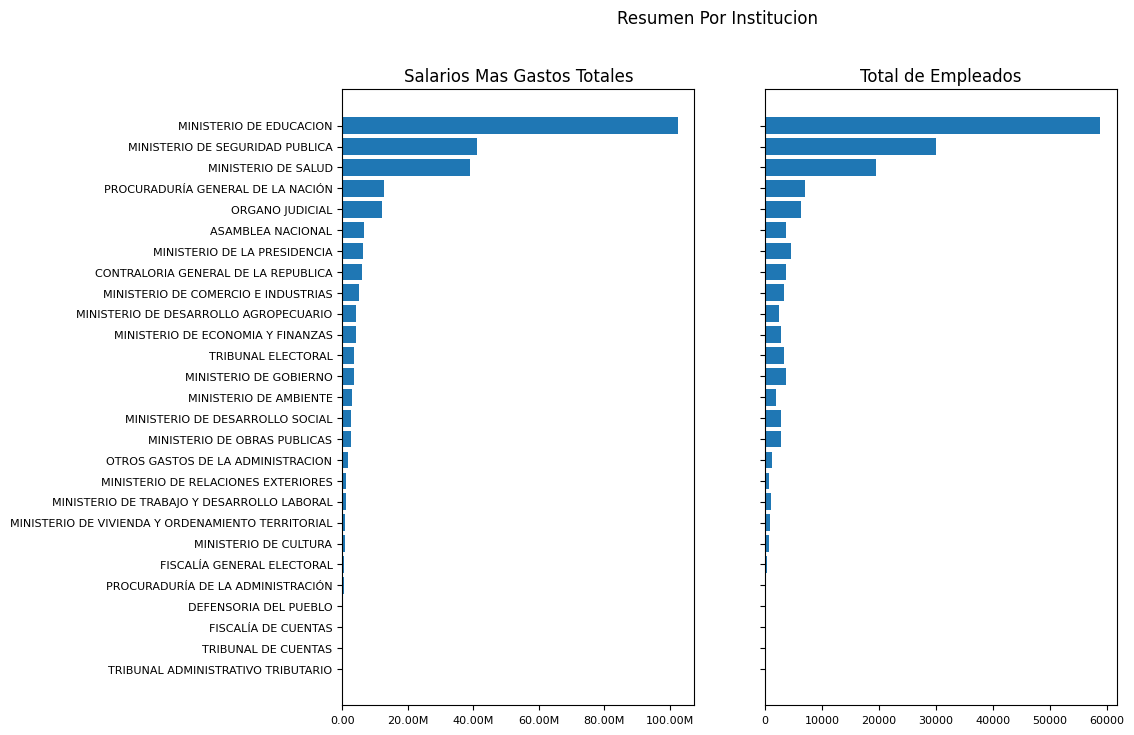

In [4]:
y = numeros_totales_df.index
x1 = numeros_totales_df.salario_mas_gasto
x2 = numeros_totales_df.total_personas

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

fig.set_figwidth(10)
fig.set_figheight(8)

ax1.barh(y, x1)
formatter = FuncFormatter(human_format)
ax1.xaxis.set_major_formatter(formatter)
ax1.tick_params(axis="both", which="major", labelsize=8)
ax1.set_title("Salarios Mas Gastos Totales")

ax2.barh(y, x2)
ax2.set_title("Total de Empleados")
ax2.tick_params(axis="both", which="major", labelsize=8)


fig.suptitle("Resumen Por Institucion", fontsize=12)

plt.show()

In [12]:
reportes_df = (
    DeltaTable.forPath(spark, silver_location)
    .toDF()
    .withColumn(
        "antiguedad", F.datediff(F.current_date(), F.col("fecha_de_inicio")) / 365
    )
    .withColumn("salario_mas_gasto", F.col("salario") + F.col("gasto"))
    .toPandas()
)
reportes_df.head(3)

,nombre,apellido,cedula,cargo,salario,gasto,estado,fecha_de_inicio,fecha_actualizacion,fecha_consulta,institucion,nombre_reporte,antiguedad,salario_mas_gasto
0,AUDINA,DE AYALA,6-0061-000611,ABOGADO I,2000.0,0.0,EVENTUAL,2020-02-01,2024-02-19 08:20:07,2024-02-29 20:55:34,MINISTERIO DE EDUCACION,file:///home/hadoop/deltalake/raw_data/Informe...,4.082192,2000.0
1,ERICK,MEDINA,8-0283-000186,ABOGADO I,2500.0,0.0,EVENTUAL,2021-09-16,2024-02-19 08:20:07,2024-02-29 20:55:34,MINISTERIO DE EDUCACION,file:///home/hadoop/deltalake/raw_data/Informe...,2.457534,2500.0
2,INDIRA,RODRIGUEZ,8-0294-000428,ABOGADO I,1800.0,0.0,EVENTUAL,2024-02-01,2024-02-19 08:20:07,2024-02-29 20:55:34,MINISTERIO DE EDUCACION,file:///home/hadoop/deltalake/raw_data/Informe...,0.079452,1800.0


Text(0.5, 1.0, 'Salarios Mas Gastos Totales')

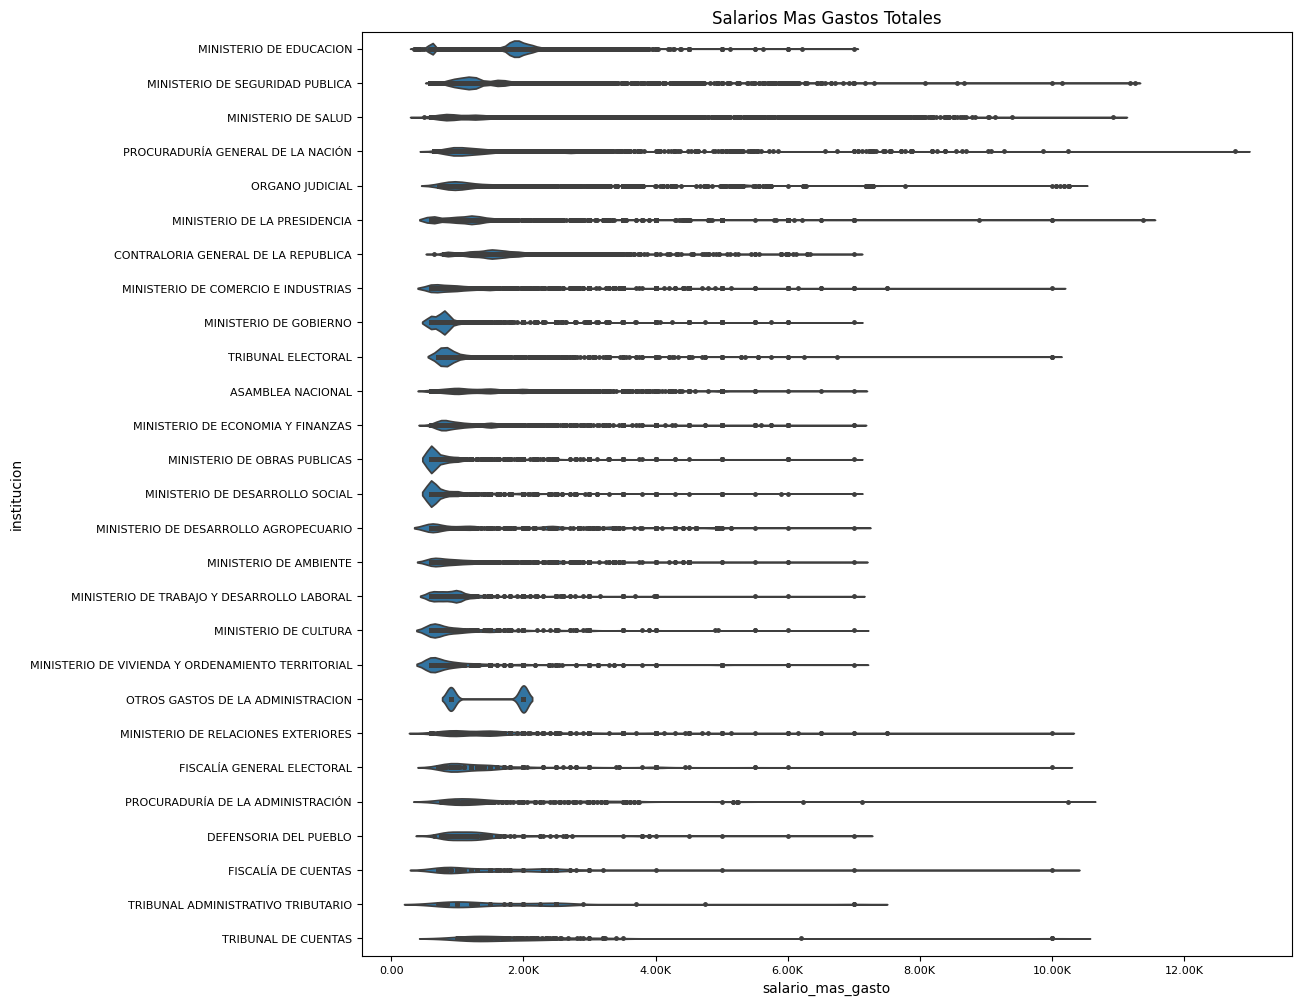

In [13]:
plt.figure(figsize=(12, 12))
fig = sns.violinplot(
    data=reportes_df,
    x="salario_mas_gasto",
    y="institucion",
    bw_adjust=0.5,
    inner="point",
)
formatter = FuncFormatter(human_format)
fig.xaxis.set_major_formatter(formatter)
fig.tick_params(axis="both", which="major", labelsize=8)
fig.set_title("Salarios Mas Gastos Totales")

In [25]:
estadistica_salarios_mas_gasto_por_insitucion = (
    reportes_df.groupby("institucion")
    .salario_mas_gasto.describe()
    .sort_values("mean", ascending=False)
    .applymap(lambda x: "{:.0f}".format(x))
)

estadistica_salarios_mas_gasto_por_insitucion.columns = ['Cantidad De Empleados','Promedio','Desviacion Estandar','Minimo','P25','Media','P75','Maximo']

estadistica_salarios_mas_gasto_por_insitucion.drop('P25',axis=1).drop('P75',axis=1).reset_index().style.set_caption(
    "Estadistica Salarios Mas Gastos por Institucion\t(Ordenado Por Salario Promedio)"
).set_table_styles([dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'black')])])

,institucion,Cantidad De Empleados,Promedio,Desviacion Estandar,Minimo,Media,Maximo
0,TRIBUNAL DE CUENTAS,117,2073,1500,1000,1700,10000
1,MINISTERIO DE SALUD,19432,2011,1563,500,1460,10921
2,ORGANO JUDICIAL,6249,1955,1567,725,1209,10264
3,PROCURADURÍA DE LA ADMINISTRACIÓN,236,1851,1245,750,1294,10240
4,MINISTERIO DE RELACIONES EXTERIORES,681,1833,1229,600,1500,10000
5,ASAMBLEA NACIONAL,3630,1807,1040,600,1500,7000
6,PROCURADURÍA GENERAL DE LA NACIÓN,7078,1796,1290,650,1280,12774
7,TRIBUNAL ADMINISTRATIVO TRIBUTARIO,89,1759,1246,700,1220,7000
8,MINISTERIO DE EDUCACION,58951,1738,570,347,1888,7000
9,MINISTERIO DE DESARROLLO AGROPECUARIO,2419,1690,1207,600,1199,7000
